### 1.观测数据分布取anchor

In [2]:
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#训练集和验证集中标注目标的宽长比
ratio_list = []
def compute_ratios(label_file):
    '''
    计算标注目标的宽长比
    '''
    with open(label_file, 'r') as label_json:
        info = json.load(label_json)
    # 根据images节点中定义的图片，去查找该图片下的标注目标
    for img in info['images']:
        img_w =img['width']
        img_h =img['height']
        for annotation in info['annotations']:
            if annotation['image_id']== img['id']:
                # 只用取标注目标的长宽，起点坐标不用
                annotation_w=annotation['bbox'][2]
                annotation_h=annotation['bbox'][3]
                # 缩放
                annotation_w = annotation_w/img_w*1333
                annotation_h = annotation_h/img_h*800
                # mmnet中是 高:宽
                ratio_list.append(annotation_h/annotation_w)

compute_ratios('./dataset_release/train.json')
compute_ratios('./dataset_release/val.json')

箱线图

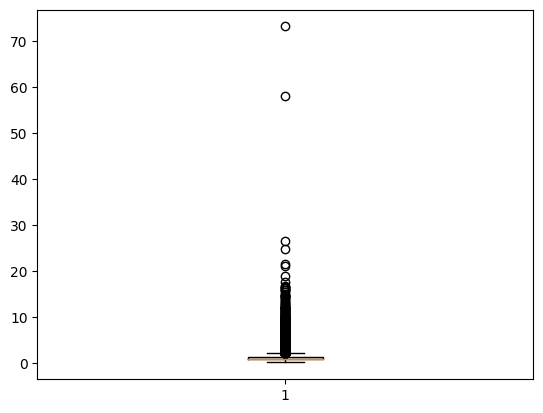

In [4]:
plt.boxplot(ratio_list)
plt.show()

处理箱型图离群点

In [5]:
# 处理箱型图离群点
def box_outlier(data):
    Q1 = np.quantile(data,q=0.25)       # 下四分位
    Q3 = np.quantile(data,q=0.75)       # 上四分位
    low_whisker = Q1 - 3 * (Q3 - Q1)    # 下边缘
    up_whisker = Q3 + 3 * (Q3 - Q1)     # 上边缘

    data_n = [x for x in data if x>=low_whisker and x<=up_whisker]
    return data_n

处理离群点后的箱线图和直方图

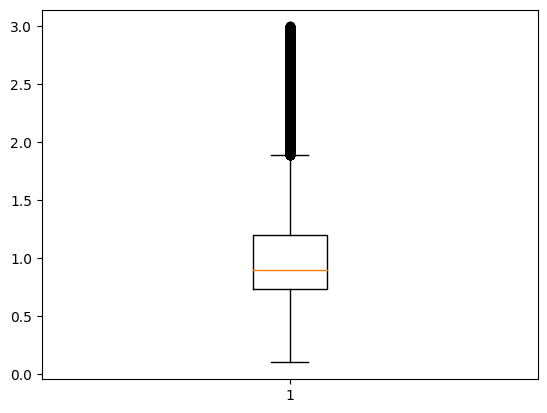

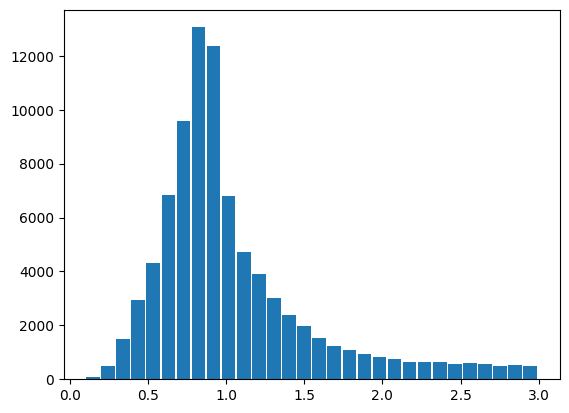

In [7]:
ratio_data =box_outlier(ratio_list)
plt.boxplot(ratio_data)
plt.show()
plt.hist(ratio_data,rwidth=0.90, bins=30)
plt.show()

取值0.2,0.5,0.8,1.2,2.5

### 2.根据新的anchor训练

In [1]:
!python mmdetection/tools/train.py mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_didi.py  \
    --cfg-options model.roi_head.bbox_head.num_classes=12 \
                  model.rpn_head.anchor_generator.ratios=[0.2,0.5,0.8,1.2,2.5]

/home/shaw/anaconda3/envs/hw5/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/shaw/anaconda3/envs/hw5/lib/python3.9/site-packages/mmdet/utils/setup_env.py:38: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
/home/shaw/anaconda3/envs/hw5/lib/python3.9/site-packages/mmdet/utils/setup_env.py:48: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please furth

### 3.改进anchor与默认结果对比

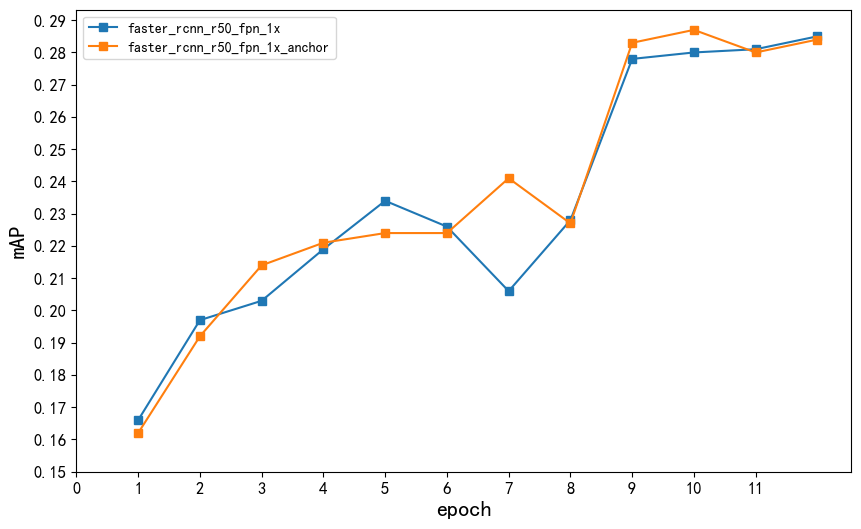

In [7]:
# 默认 数据来源：1.train_faster_rcnn_r51_epochs20.ipynb
result_default = [0.166,0.197,0.203, 0.219,0.234,0.226,0.206,0.228,0.278,0.28,0.281,0.285]
# 更改 anchor: 参见上面的运行结果
result_anchor = [0.162,0.192,0.214,0.221,0.224,0.224,0.241,0.227,0.283,0.287,0.28,0.284]

plt.figure(figsize=(10,6), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
plt.plot(range(1,13), result_default, marker='s', label ='faster_rcnn_r50_fpn_1x')
plt.plot(range(1,13), result_anchor, marker='s', label ='faster_rcnn_r50_fpn_1x_anchor')
plt.xlabel('epoch', fontsize=16)
plt.xticks(range(0,12), fontsize=12)
plt.ylabel('mAP', fontsize=16)
plt.yticks(np.arange(150,300,10)/1000,fontsize=12)
plt.legend()
plt.show()
